In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import math
import torch
import numpy as np
import scipy
from scipy import ndimage

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM
# from DiffNet.datasets.single_instances.rectangles import RectangleManufactured
# from DiffNet.datasets.single_instances.rectangles import SpaceTimeRectangleManufactured
from pc_complex_immersed_background import PCVox, Poisson

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42


In [3]:
def plot_contours(k,f,u,u_exact):
    diff = u - u_exact
    # plotting        
    fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])              

    # print(np.linalg.norm(diff.flatten())/self.domain_size)
    im = axs[0].imshow(f,cmap='jet')
    # fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
    fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$f$')
    im = axs[1].imshow(k,cmap='jet')
    fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
    im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
    fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
    im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
    fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
    im = axs[4].imshow(diff,cmap='jet')
    fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
    plt.show()
    # plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
    # self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
    # plt.close('all')

In [4]:
# filename = 'bunny-18.png'
filename = 'bonefishes-1.png'
domain_size = 256
dataset = PCVox(filename, domain_size=domain_size)
u_tensor = np.ones((1,1,domain_size,domain_size))
network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
basecase = Poisson(network, dataset, batch_size=1, domain_size=domain_size)

# ------------------------
# 1 INIT TRAINER
# ------------------------
logger = pl.loggers.TensorBoardLogger('.', name="pc_complex_immersed_background")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(gpus=[0],callbacks=[early_stopping],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=5, deterministic=True, profiler='simple')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [5]:
# ------------------------
# 4 Training
# ------------------------

trainer.fit(basecase)

# ------------------------
# 5 SAVE NETWORK
# ------------------------
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type          | Params
-----------------------------------------------
0 | network      | ParameterList | 65.5 K
1 | N_gp         | ParameterList | 16    
2 | dN_x_gp      | ParameterList | 16    
3 | dN_y_gp      | ParameterList | 16    
4 | d2N_x_gp     | ParameterList | 16    
5 | d2N_y_gp     | ParameterList | 16    
6 | d2N_xy_gp    | ParameterList | 16    
7 | N_gp_surf    | ParameterList | 4     
8 | dN_x_gp_surf | ParameterList | 4     
9 | dN_y_gp_surf | ParameterList | 4     
-----------------------------------------------
65.5 K    Trainable params
108       Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)
/work/baskarg/bkhara/python_virtual_envs/py-3.7.7-b5s6jni/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value

Epoch 4: 100%|█████████████████████████████████| 100/100 [00:02<00:00, 40.67it/s, loss=-4.05, v_num=4_4]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  21.14          	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  3.3472         	|5              	|  16.736         	|  79.167         	|
run_training_batch                 	|  0.027254       	|500            	|  13.627         	|  64.462         	|
optimizer_step_with_closure_0      	|  0.027063       	|500            	|  13.531         	|  64.008         	|
training_step_and_backward         	|  0.0047207      	|1304           	|  6.1557         	|  29.119         	|
model_forward                      

In [16]:
# separate query
version_id = 4
case_dir = './pc_complex_immersed_background/version_'+str(version_id)
# filename = 'bunny-18.png'
filename = 'bonefishes-1.png'
dataset = PCVox(filename, domain_size=domain_size)
network = torch.load(os.path.join(case_dir, 'network.pt'))
equation = Poisson(network, dataset, batch_size=1, domain_size=domain_size)
# Query
inputs, forcing = equation.dataset[0:1]
up = equation.do_query(inputs, forcing) 
u = up.detach().squeeze().numpy()

# u_exact = equation.u_exact.squeeze()

# # plot
# plot_contours(k,f,u,u_exact)

# nsample = len(basecase.dataset)
# print("nsample = ", nsample)

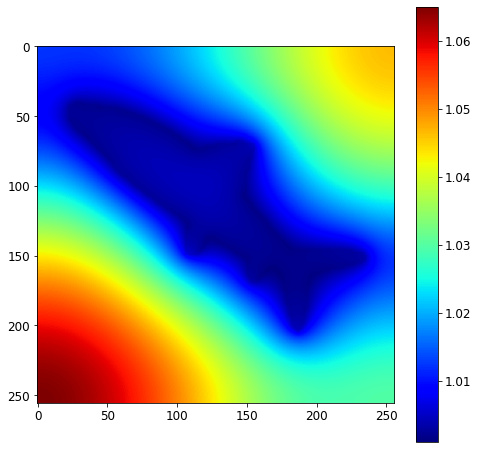

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(u, cmap='jet')
plt.colorbar()

In [18]:
pc = inputs[0:1,:,:].squeeze()
normals = inputs[1:2,:,:].squeeze()

In [19]:
u_pts, u_x_pts, u_y_pts = equation.loss_calc_inspect(up, inputs.unsqueeze(0), forcing.unsqueeze(0))

In [20]:
print(up.shape, pc.shape, normals.shape, u_pts.shape, u_x_pts.shape, u_y_pts.shape)

torch.Size([1, 1, 256, 256]) torch.Size([832, 2]) torch.Size([832, 2]) torch.Size([1, 1, 832]) torch.Size([1, 1, 832]) torch.Size([1, 1, 832])


In [21]:
grad_vec = torch.stack((u_x_pts.detach().squeeze(), u_y_pts.detach().squeeze()), dim=0)
grad_vec = grad_vec.T

In [22]:
grad_vec.shape

torch.Size([832, 2])

In [23]:
grad_mag = torch.sqrt(torch.sum(grad_vec**2, dim=1, keepdim=True))
grad_mag.shape

torch.Size([832, 1])

In [24]:
grad_vec_unit = grad_vec/grad_mag
grad_vec_unit.shape

torch.Size([832, 2])

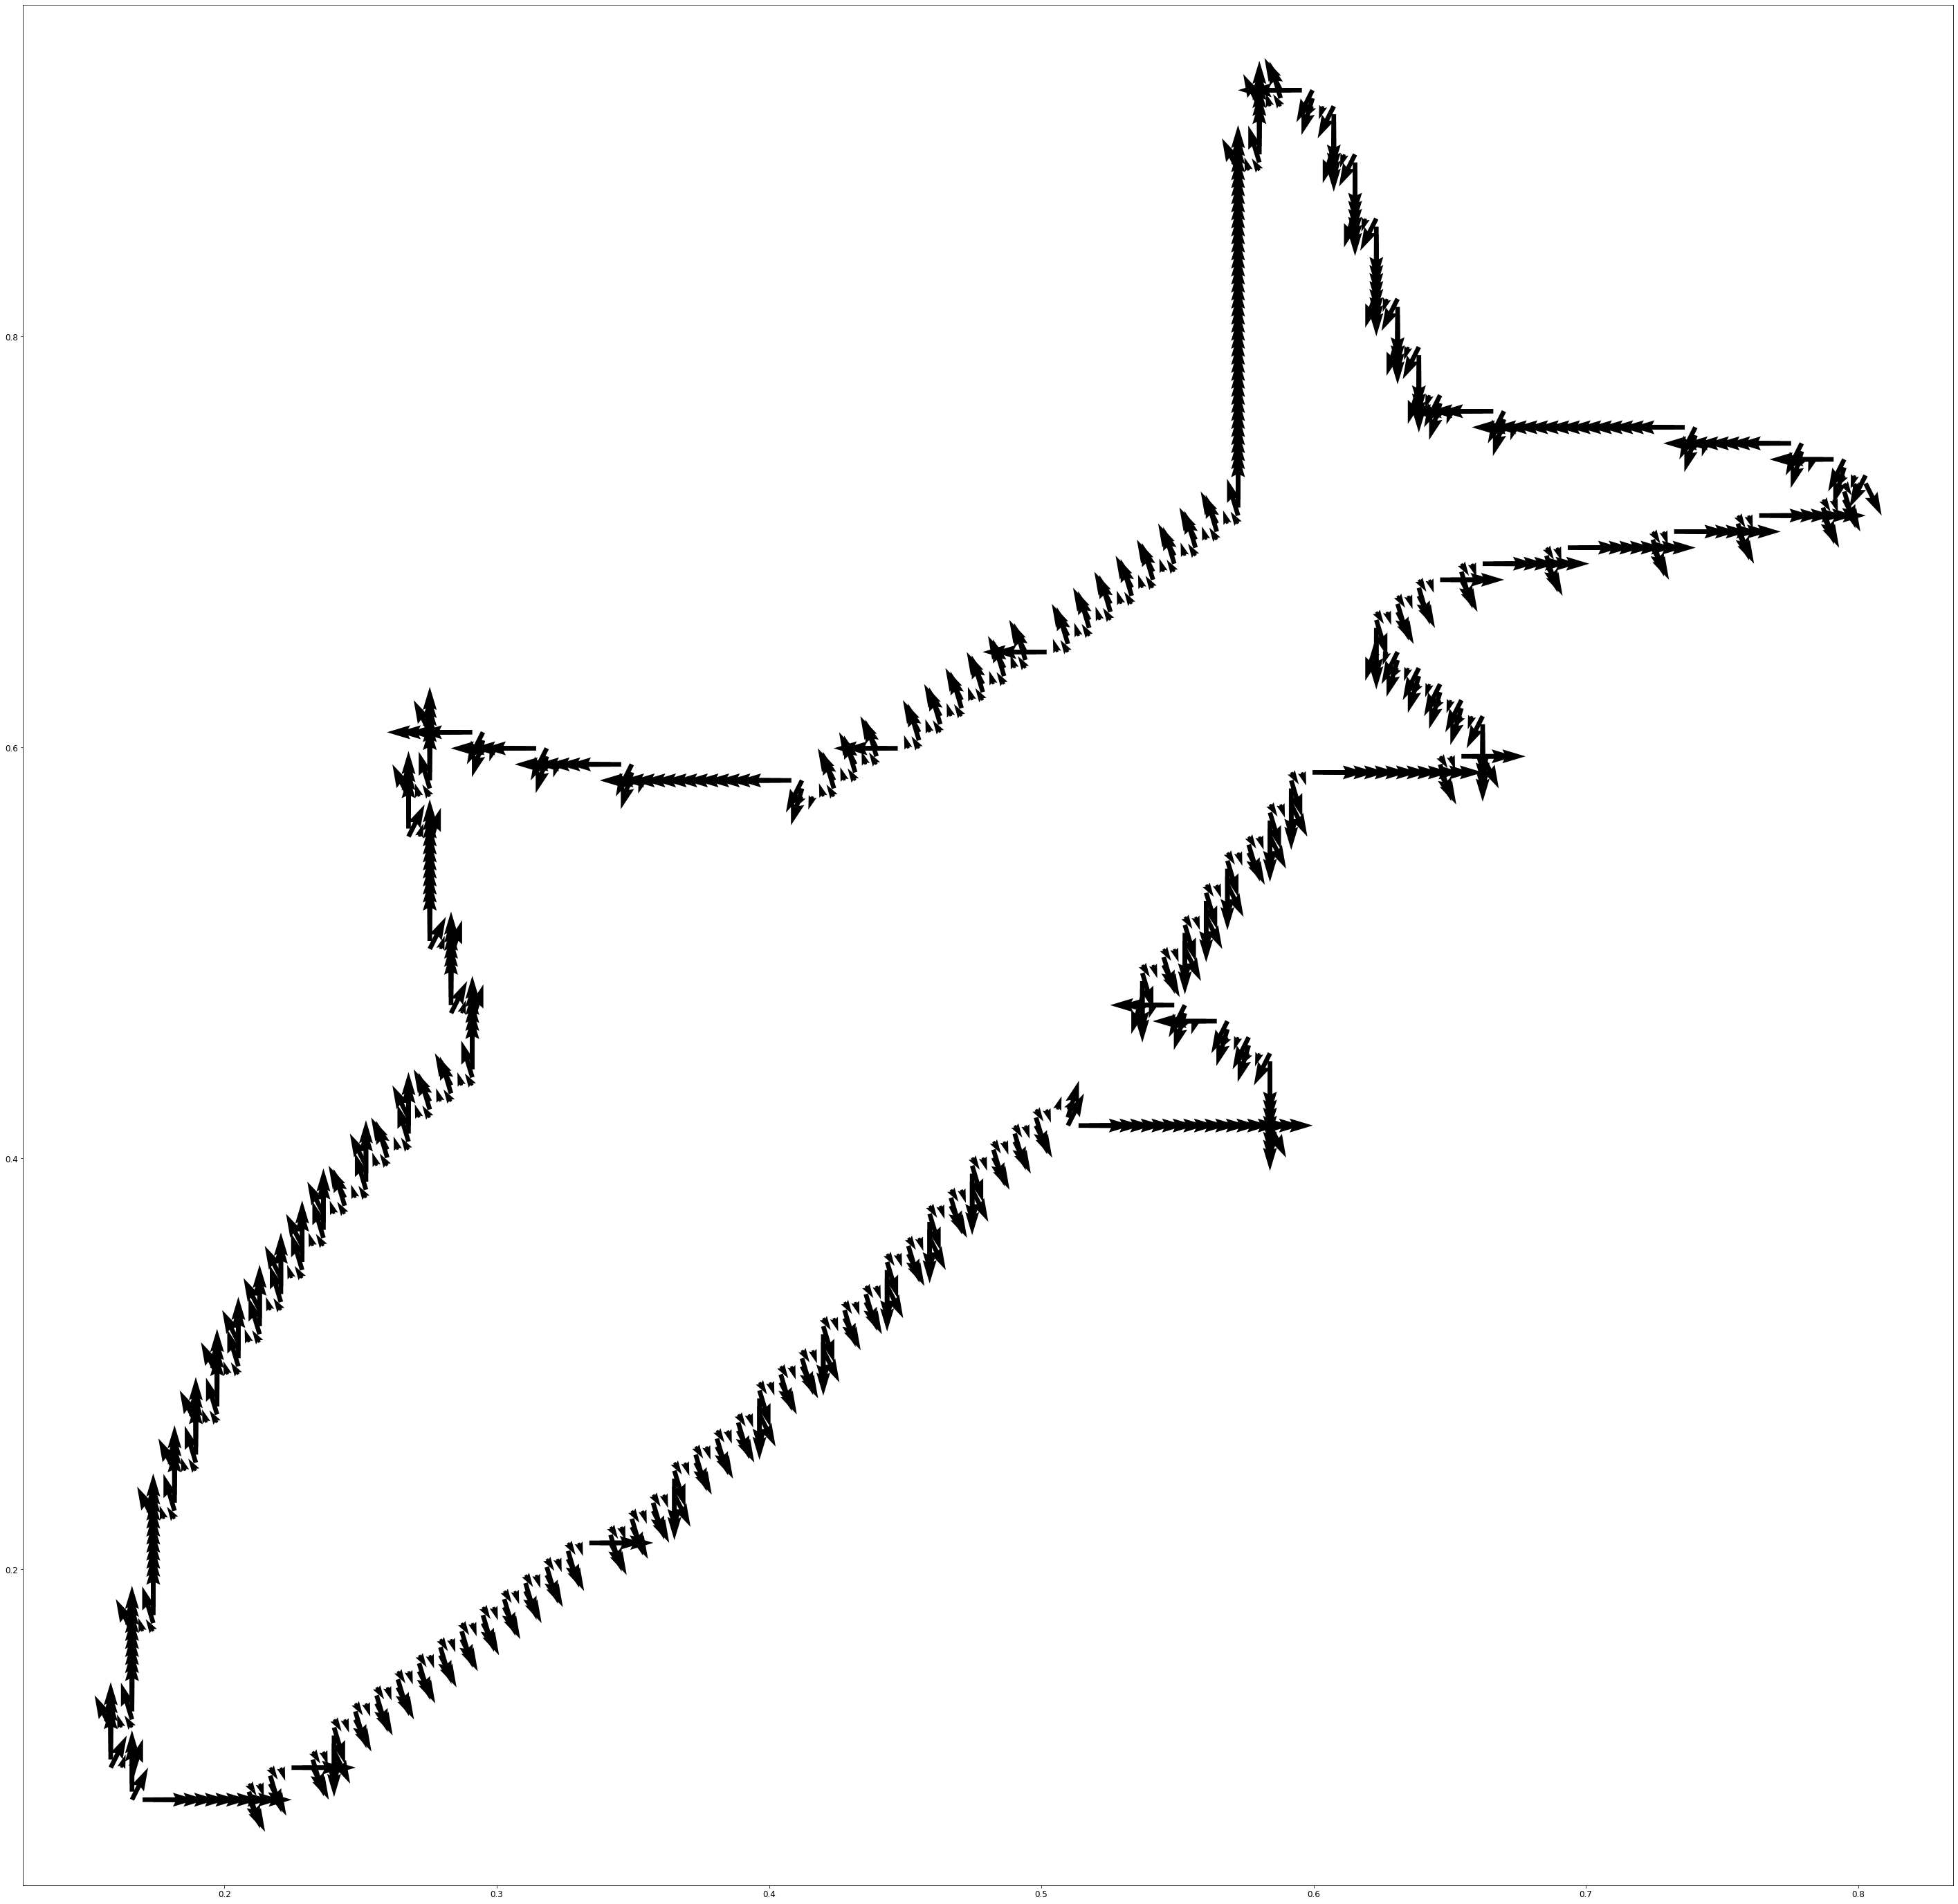

In [25]:
plt.figure(figsize=(50,50))
plt.quiver(pc[:,0],pc[:,1], normals[:,0], normals[:,1])
# plt.savefig("./bunny-input-normals.png")
plt.savefig("./bonefish-input-normals.png")

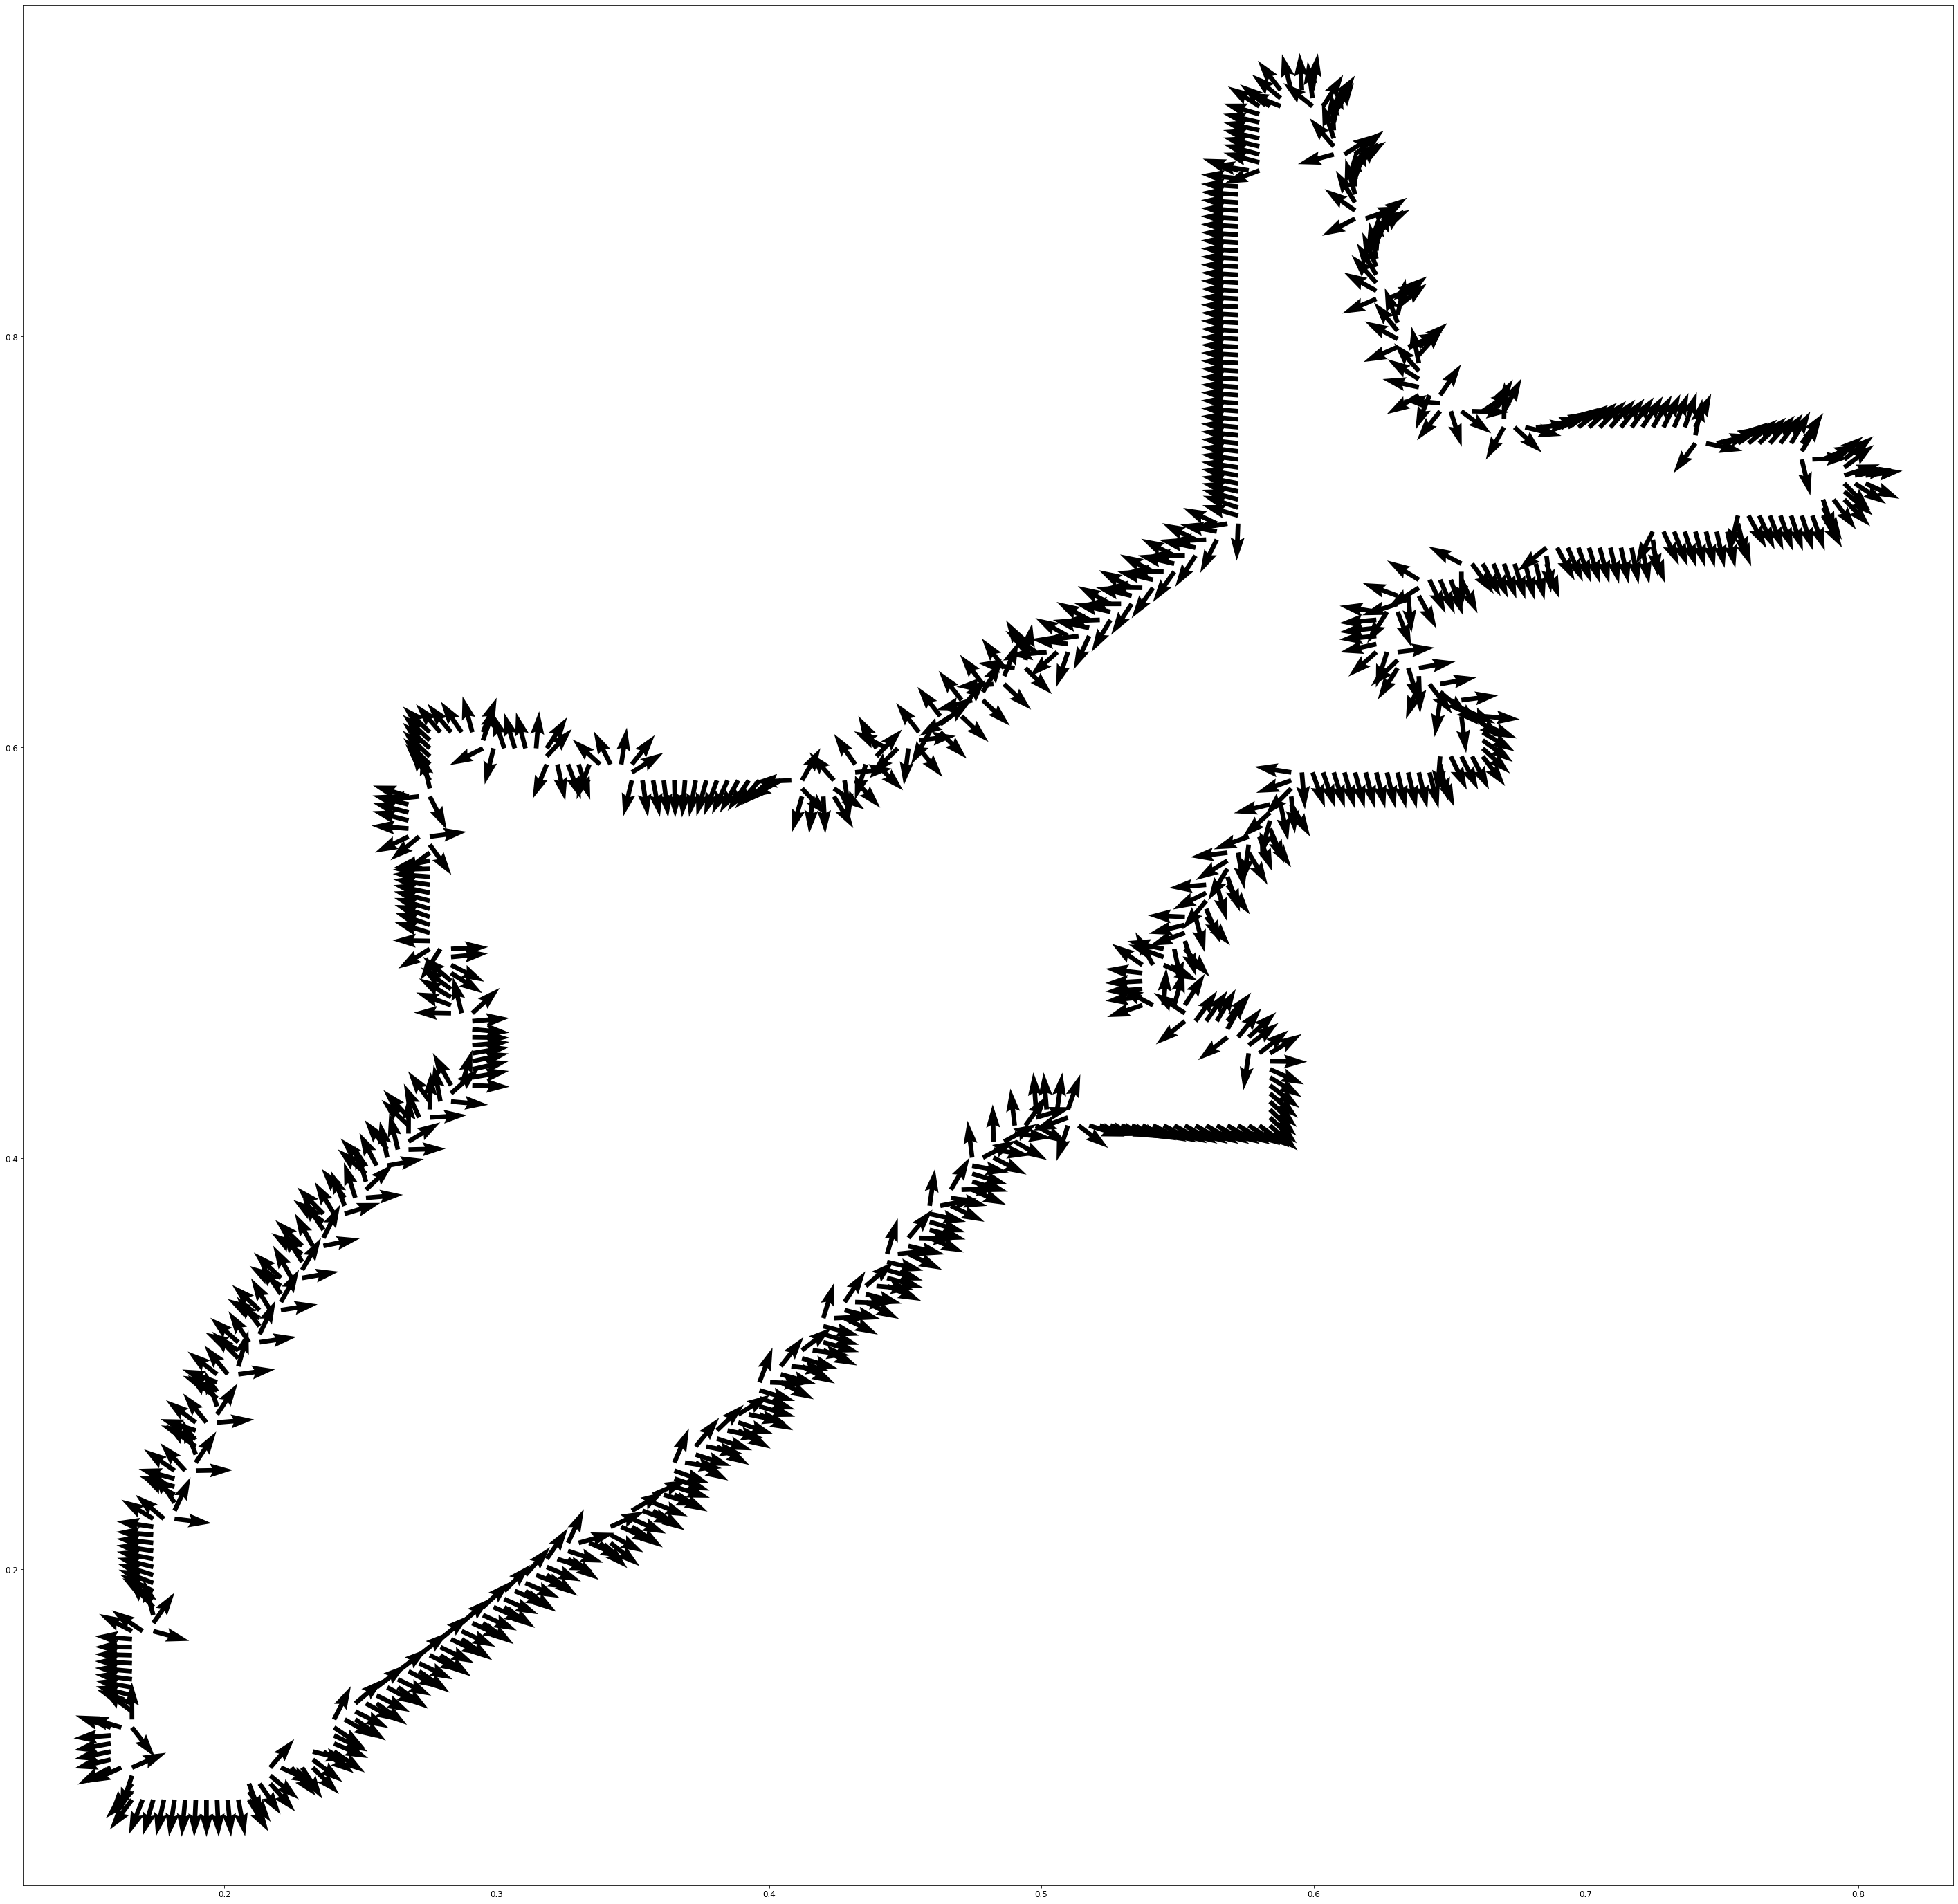

In [26]:
plt.figure(figsize=(50,50))
plt.quiver(pc[:,0],pc[:,1], grad_vec_unit[:,0], grad_vec_unit[:,1])
# plt.savefig("./bunny-poisson-gradients.png")
plt.savefig("./bonefish-poisson-gradients.png")

In [21]:
X = ndimage.distance_transform_edt(1-bc1) / domain_size

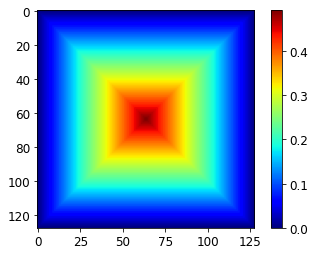

In [22]:
plt.imshow(X, cmap='jet')
plt.colorbar()

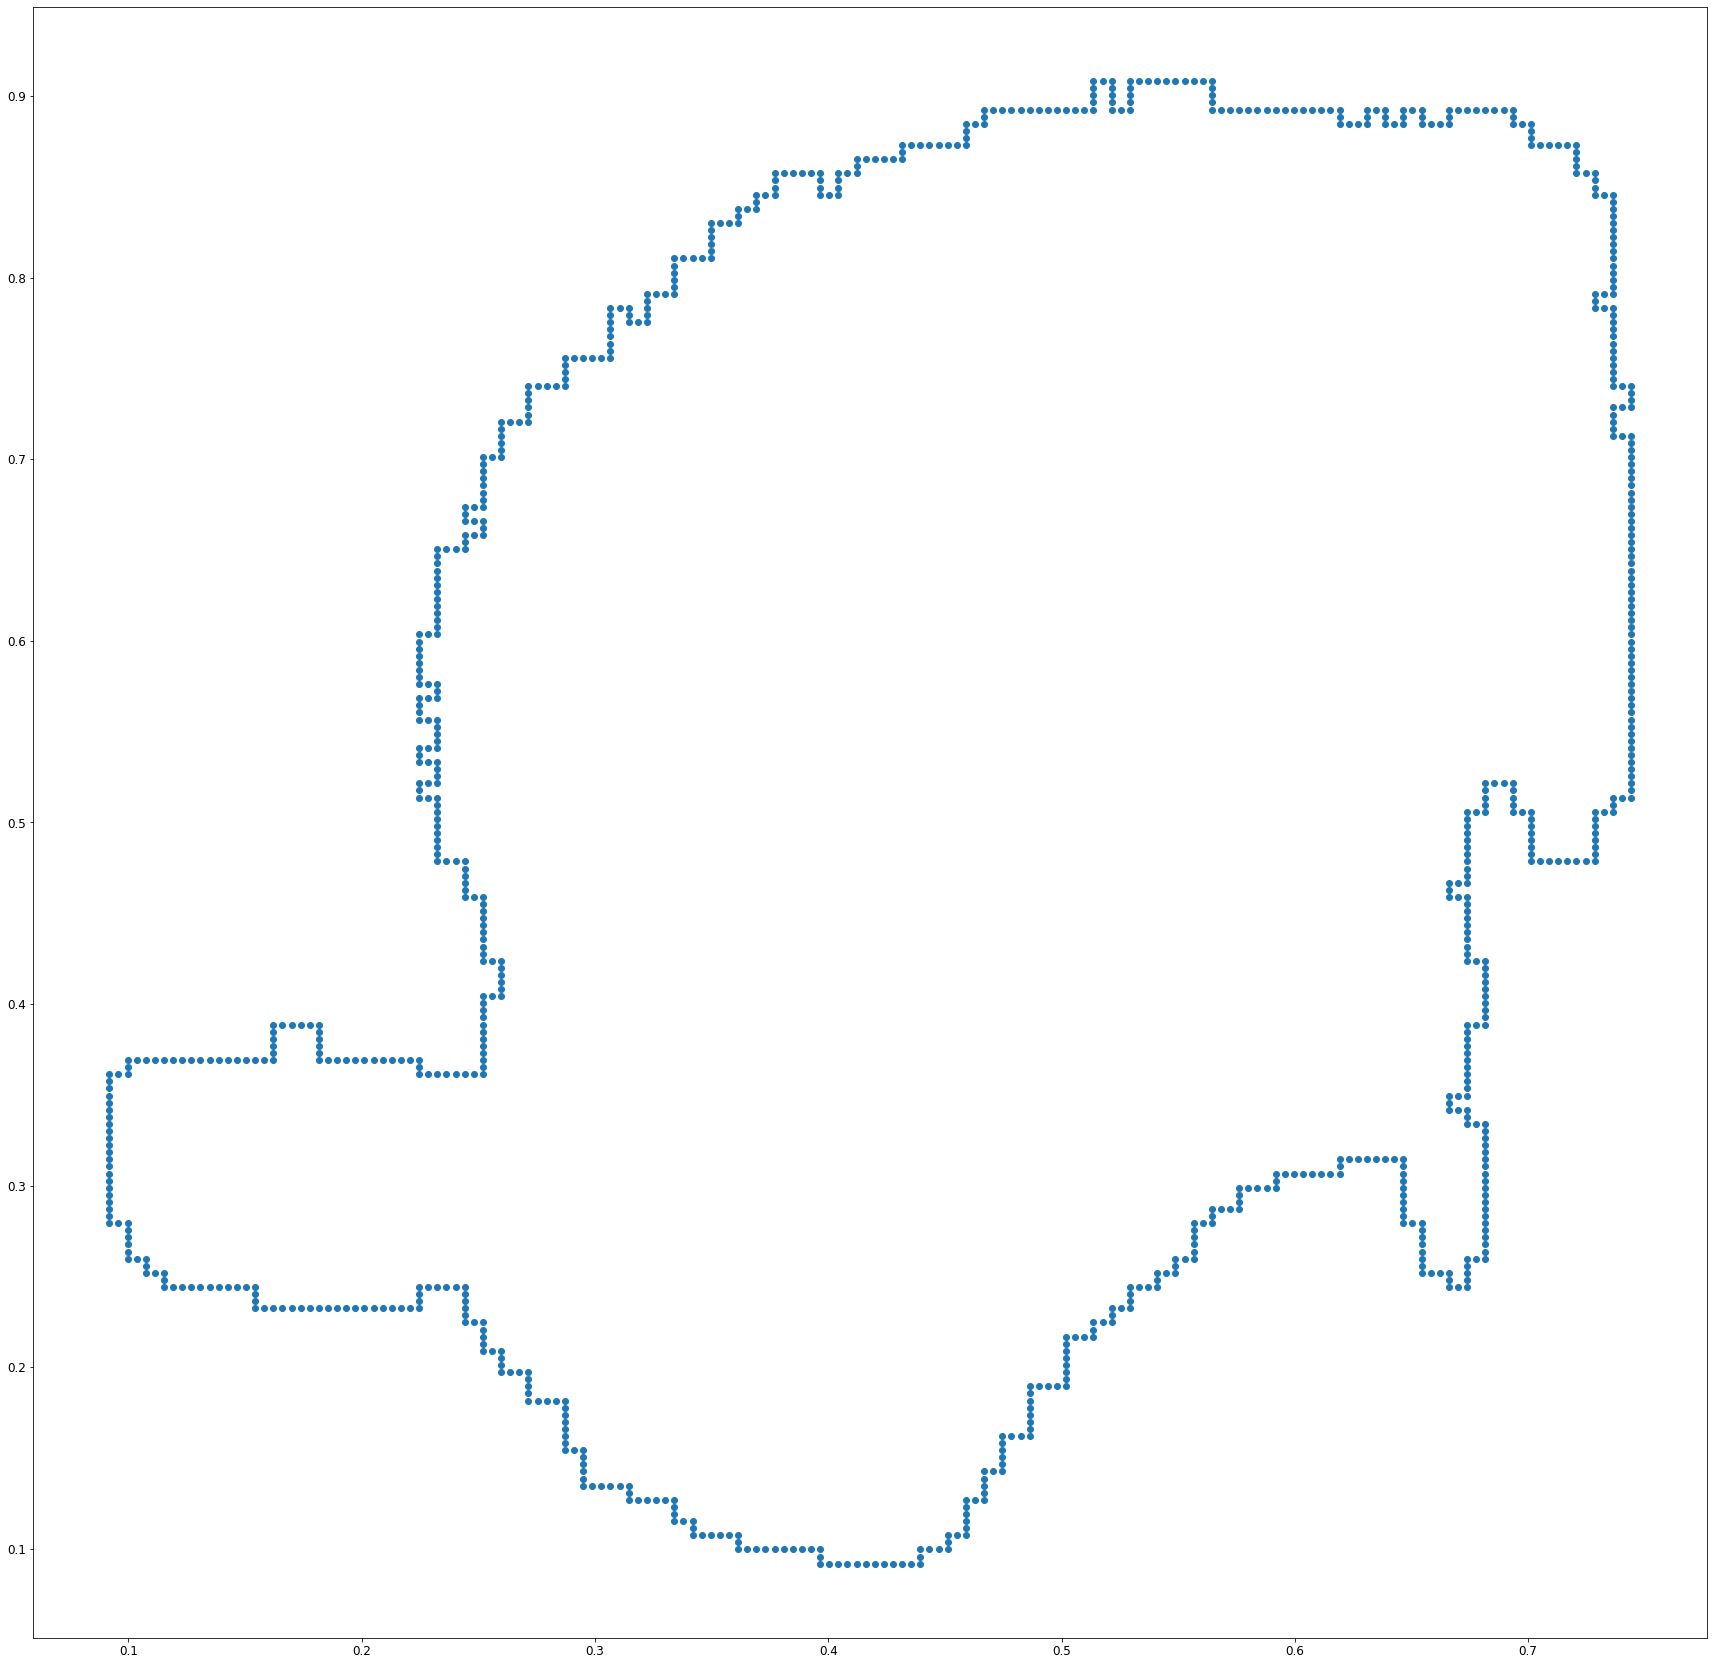

In [42]:
plt.figure(figsize=(30,30))
plt.scatter(pc[:,0], pc[:,1])

In [14]:
dataset.normals.shape

(832, 2)

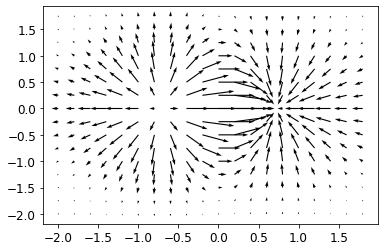

In [15]:
x,y = np.meshgrid(np.arange(-2, 2, .2), np.arange(-2, 2, .25))
z = x*np.exp(-x**2 - y**2)
v, u = np.gradient(z, .2, .2)
fig, ax = plt.subplots()
q = ax.quiver(x,y,u,v)
plt.show()

In [19]:
v.shape

(16, 20)

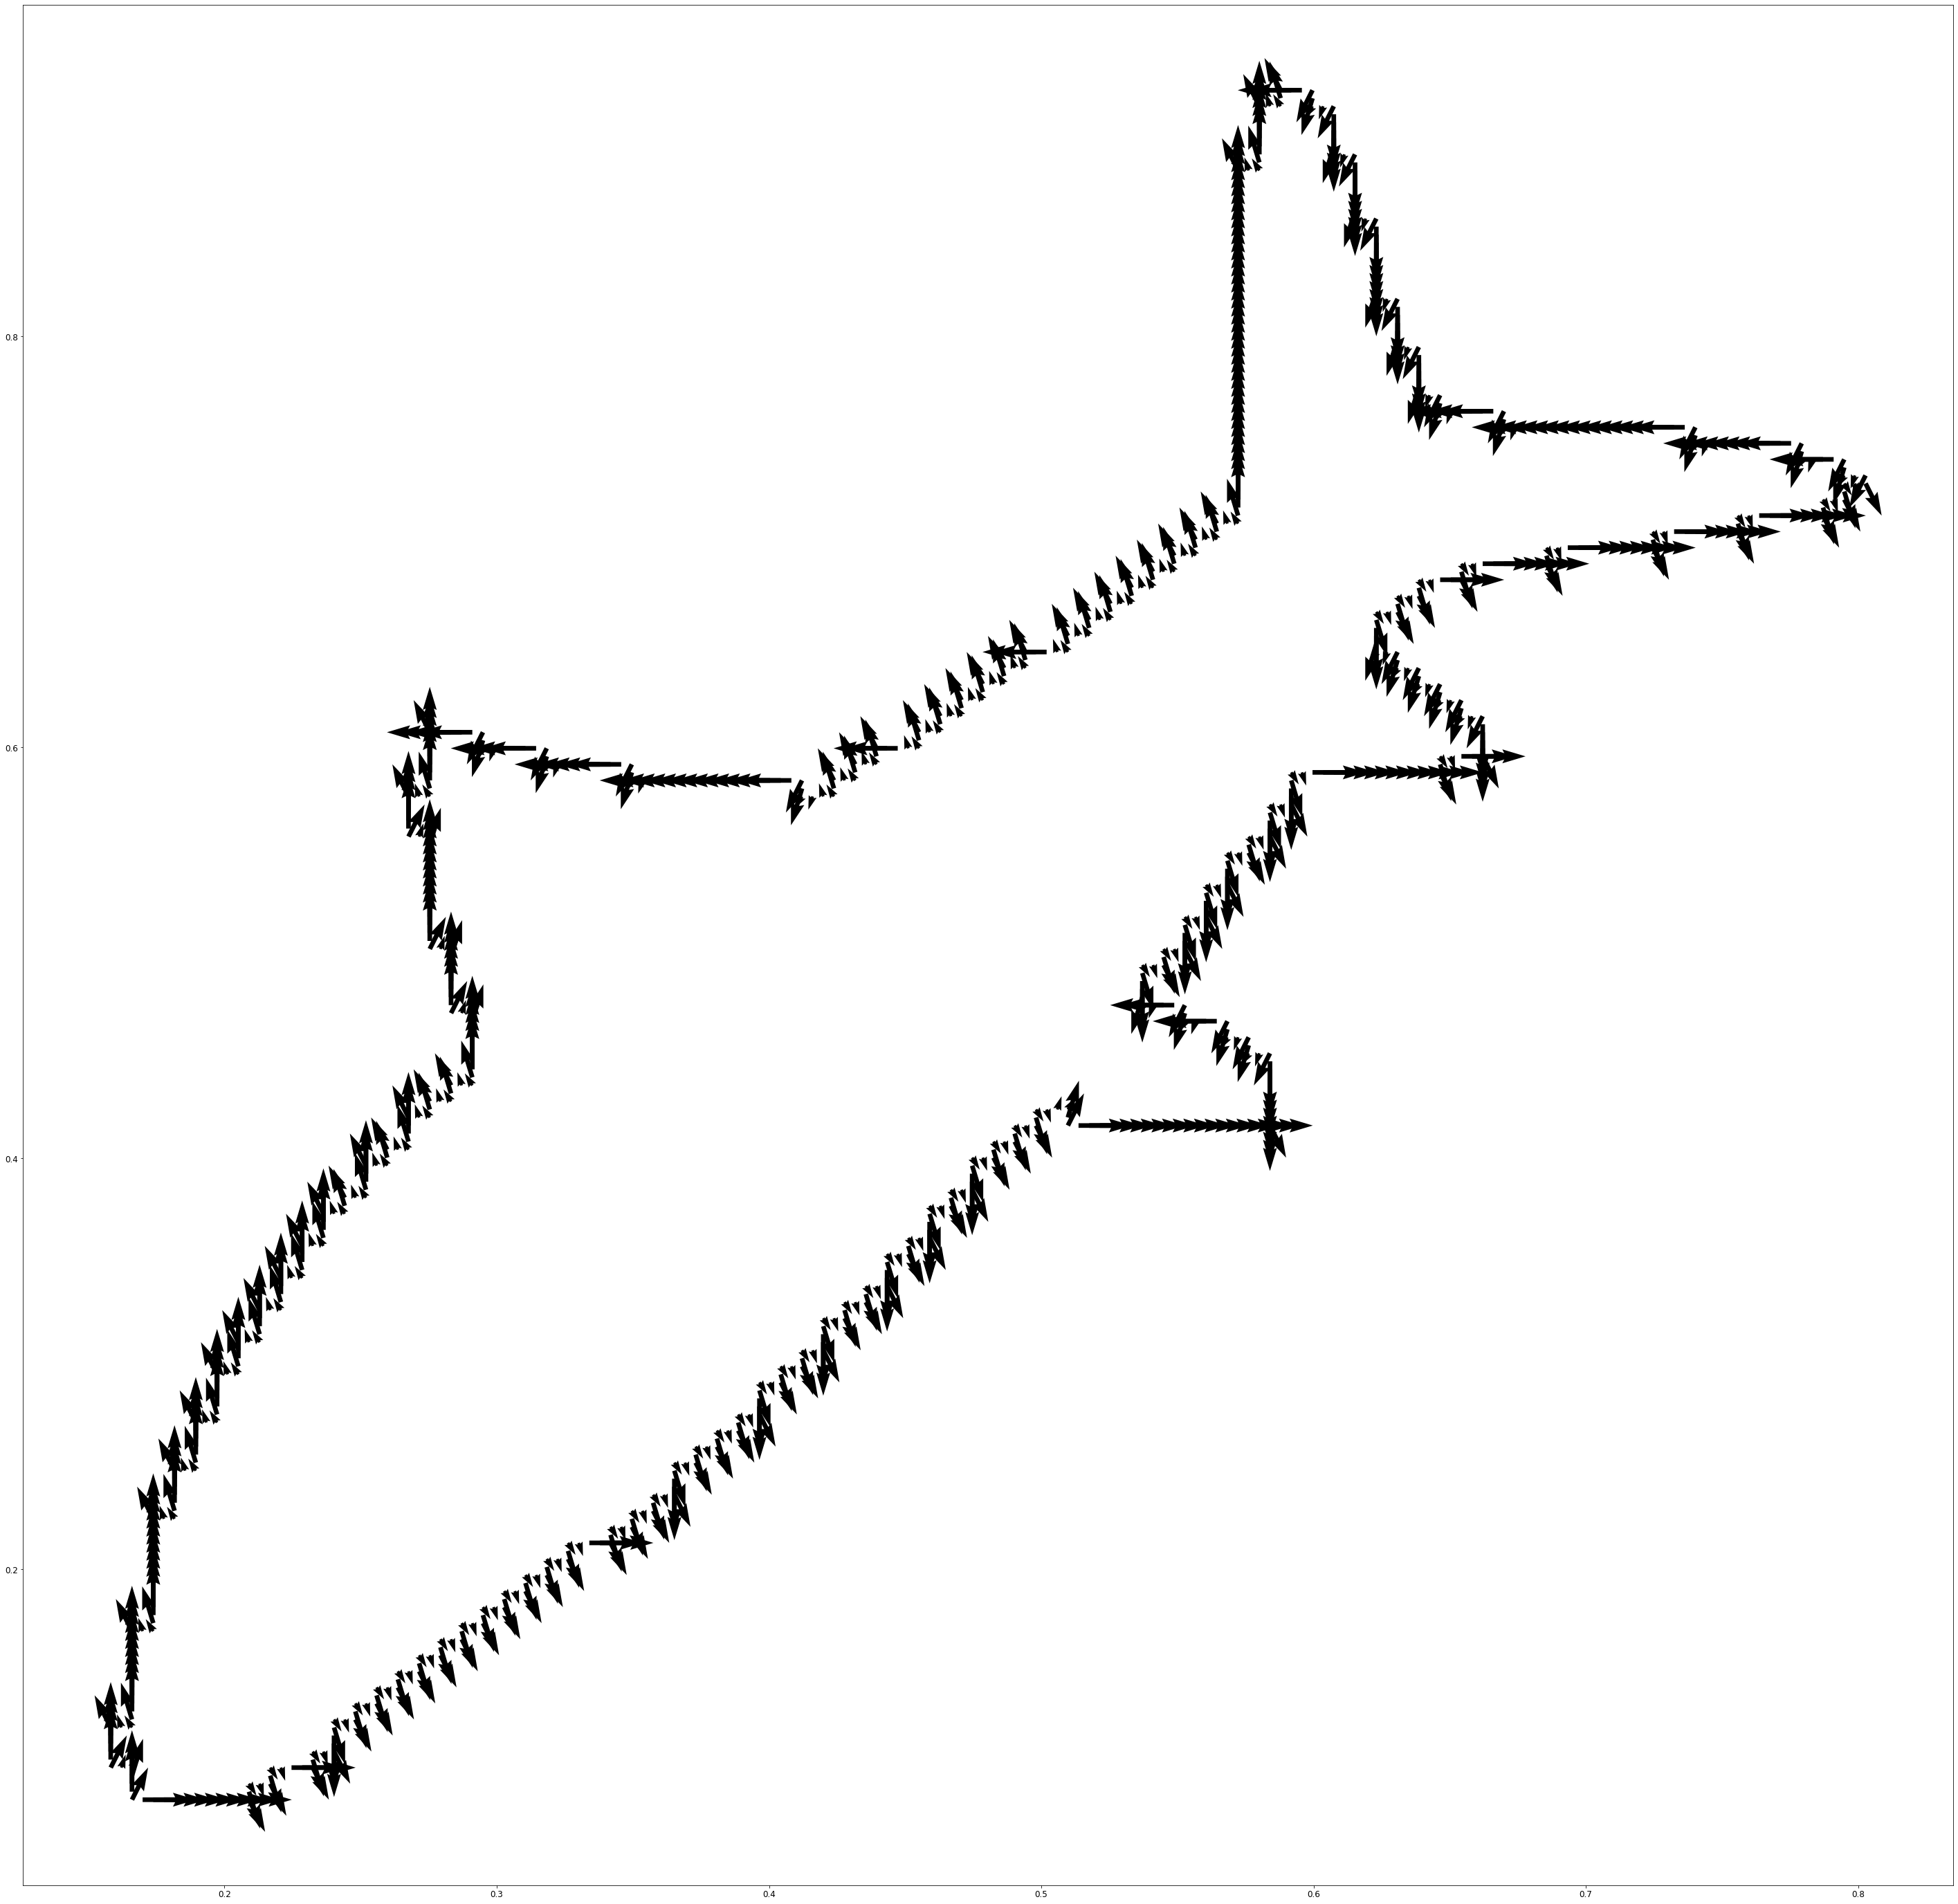

In [22]:
plt.figure(figsize=(50,50))
plt.quiver(dataset.pc[:,0],dataset.pc[:,1], dataset.normals[:,0], dataset.normals[:,1])
plt.savefig("./bonefish-normals.png")

In [1]:
!nvidia-smi

Thu May 12 20:52:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:01:00.0 Off |                    0 |
| N/A   35C    P0    77W / 500W |   2082MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:41:00.0 Off |                    0 |
| N/A   